# Cramer-Rao Bound Calcuation for the Single Point Saturation based qMT
This notebook replicates last column of Tab. 1 in the paper [Rapid quantitative magnetization transfer imaging: utilizing the hybrid state and the generalized Bloch model](https://doi.org/10.48550/arXiv.2207.08259), i.e. it calculates the Cramer-Rao bound (CRB) of [Yarnykh's single off‐resonance saturation qMT approach](https://doi.org/10.1002/mrm.25811). 

First, we load all required packages:

In [1]:
using MRIgeneralizedBloch
using MRIgeneralizedBloch: propagator_linear_inversion_pulse, xs_destructor
using LinearAlgebra
BLAS.set_num_threads(1) # single threaded is faster in this case
using StaticArrays
using Statistics
using SpecialFunctions
using DifferentialEquations
using Plots

Define the point in parameter space at which the CRB will be calculated:

In [2]:
m0s = 0.1
R1a = 0.625 # 1/s
R1f = R1a   # 1/s
R1s = R1a   # 1/s
R2f = 15    # 1/s
Rx  = 30    # 1/s
T2s = 10e-6 # s
R2slT = precompute_R2sl()

ω0 = 0    # rad/s
B1 = 1;   # in units of B1_nominal

Interpolate the Green's function and its derivative wrt. $T_2^s$ (for speed purposes):

In [3]:
G = interpolate_greens_function(greens_superlorentzian, 0, 2000)
dGdT2s = interpolate_greens_function(dG_o_dT2s_x_T2s_superlorentzian, 0, 2000);

The next cell defines the gradients that are accounted for in the CRB calculation. We note that [Yarnykh](https://doi.org/10.1002/mrm.25811) suggests to fixed the ratio $R_2^f/R_1^a$. Therefore, we calculate both gradients and merge them later. 

Further, we initialize the Jacobian matrix. The first dimension is of size 6 for 6 acquired data points: we perform variable flip angle scans with 2 flip angles and one saturation scan. For each scan, we record two echoes to improve SNR, as proposed by [Yarnykh](https://doi.org/10.1002/mrm.25811). 

In [4]:
grad_list = [grad_m0s(), grad_R1a(), grad_R2f()]
J = Matrix{ComplexF64}(undef, 6, length(grad_list)+1);

Define the thermal equilibrium magnetization and initialize a function $m(t)$ that will be used to solve the [generalized Bloch model's](https://doi.org/10.1002/mrm.29071) integro-differential equation:

In [5]:
m0 = [0; 0; 1-m0s; m0s; 1; zeros(5*length(grad_list))]
mfun(p, t; idxs=nothing) = typeof(idxs) <: Number ? m0[idxs] : m0;

Define indices that point at the x-magnetization and both transversal magnetization components and their derivatives wrt. all model parameters:

In [6]:
idx_xf = 5 .* (0:length(grad_list)) .+ 1
idx_xy = [idx_xf; idx_xf .+ 1];

## Simulate the first vFA scan with 4 degrees
We use the timings and the flip angles suggested in [this paper](https://doi.org/10.1002/mrm.25811):

In [7]:
TRF_exc = 1e-3 # s
TR = 21e-3   # s
TE1 = 2.3e-3   # s
TE2 = 6.9e-3   # s
α_exc = 4 * π/180 # 4deg pulse
TvFA = 2 * TR; # total scan time; 2 for the 4deg and 25deg scan



We heuristically simulate 500 RF-pulse and check with below plot that the magnetization has reach a steady state. Then entries to the Jacobian (two for two echoes) are repeatedly over-written so that only the last steady state data-point is recorded. 

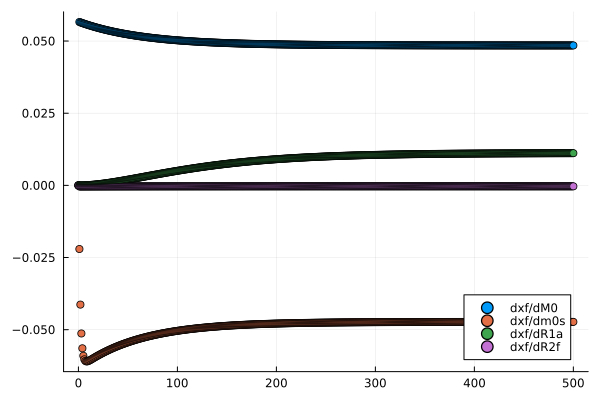

In [8]:
m = copy(m0)
colors = palette(:default)[1:length(idx_xf)]'
p = scatter(0*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=["dxf/dM0" "dxf/dm0s" "dxf/dR1a" "dxf/dR2f"])
for i = 1 : 500
    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TR - TE2 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    m[idx_xy] .= 0 # assume perfect spoiling

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TRF_exc), (α_exc/TRF_exc, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE1 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[1,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE2 - TE1), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[2,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    scatter!(p, i*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=:none)
end
plot(p)

## Simulate the second vFA scan with 25 degrees
We repeat the same simulation with a larger flip angle:

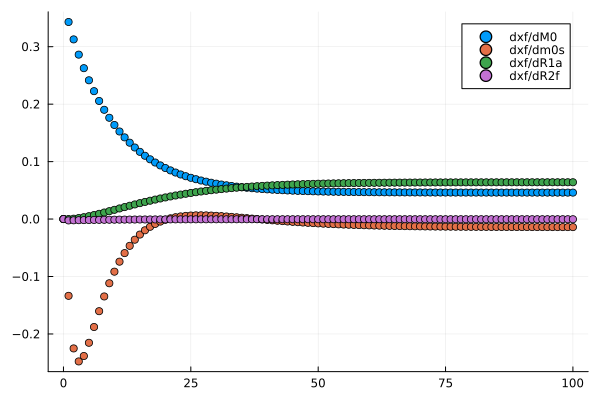

In [9]:
α_exc = 25 * π/180

m = copy(m0)
p = scatter(0*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=["dxf/dM0" "dxf/dm0s" "dxf/dR1a" "dxf/dR2f"])
for i = 1 : 100
    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TR - TE2 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    m[idx_xy] .= 0 # assume perfect spoiling

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TRF_exc), (α_exc/TRF_exc, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE1 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[3,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE2 - TE1), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[4,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    scatter!(p, i*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=:none)
end
plot(p)

## Simulate the off-resonance saturation scan
We use the timings and the flip angles suggested in [this paper](https://doi.org/10.1002/mrm.25811) and define a sinc-shaped saturation pulse with no side-lobes:

In [10]:
TRF_sat = 12e-3 # duration of the saturation pulse in s
ω0 = 4e3* 2π    # off-resonance frequency of the saturation pulse in rad/s (= 4kHz)
α_sat = 560 * π/180 # rad/s (= 560deg)

NSideLobes = 0
ω1_sat(t) = sinc(2(NSideLobes+1) * t/TRF_sat - (NSideLobes+1)) * α_sat / (sinint((NSideLobes+1)π) * TRF_sat/π / (NSideLobes+1));

We define a 10deg, 1ms rectangular excitation pulse:

In [11]:
TRF_exc = 1e-3 # s
α_exc = 10 * π/180 # rad/s
ω1_exc(_) = α_exc/TRF_exc;

And use the $T_R$ from [Yarnykh's paper](https://doi.org/10.1002/mrm.25811):

In [12]:
TR = 28e-3 # s
T_sat = TR; # scan time = TR in this case (single off-resonance approach)

and perform the simulation, writing the derivatives of the last $T_R$ into the Jacobian:

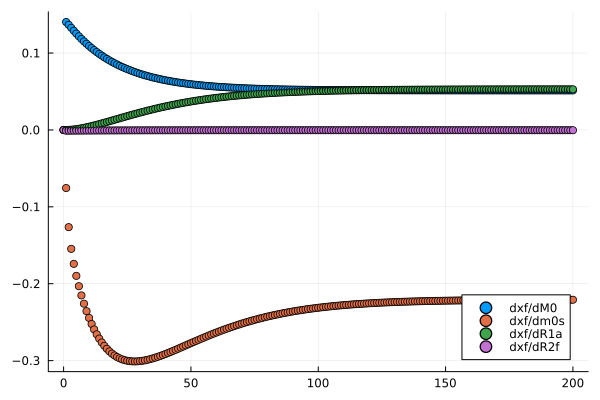

In [13]:
m = copy(m0)
p = scatter(0*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=["dxf/dM0" "dxf/dm0s" "dxf/dR1a" "dxf/dR2f"])
for i = 1 : 200
    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TR - TRF_sat - TE2 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    m[idx_xy] .= 0 # assume perfect spoiling

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TRF_sat), (ω1_sat, B1, ω0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    m[idx_xy] .= 0

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TRF_exc), (ω1_exc, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE1 - TRF_exc/2), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[5,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    sol = solve(DDEProblem(apply_hamiltonian_gbloch!, m, mfun, (0, TE2 - TE1), (0, B1, 0, m0s, R1f, R2f, Rx, R1s, T2s, G, dGdT2s, grad_list)))
    m .= sol[end]
    J[6,:] .= m[idx_xf] .+ 1im .* m[(idx_xf .+1)]

    scatter!(p, i*ones(length(idx_xf))', m[idx_xf]', c=colors, labels=:none)
end
plot(p)

## Calculate the Cramer-Rao bound values
As mentioned above, Yarnykh suggested to fix the ratio $R_1^a/R_2^f$. Hence, we extract only the first three components of the Jacobian that correspond to the gradients wrt. $M_0$, $m_0^s$, and $R_1^a$. To the latter, we add the gradient wrt. $R_2^f$, normalized according to the chain rule.

In [14]:
Jt = J[:,1:3]
Jt[:,3] .+= J[:,4] ./ (R1a / R2f);

The following cell calculates the CRB values and normalizes them by the scan time. Like for the other cases in Tab. 1, we consider each k-space line as a single data point with unit noise variance (this is equivalent to a normalization with the noise variance). 

In [15]:
CRB = real.(diag(inv(Jt' * Jt)))
CRB .*= TvFA + T_sat;

Normalized CRB of $m_0^s$ in seconds:

In [16]:
CRB[2]/m0s^2

146.14790795448823

Normalized CRB of $R_1^f$ in seconds:

In [17]:
CRB[3]/R1a^2


51.49921497478081

Normalized CRB of $M_0$ in seconds:

In [18]:
CRB[1]


20.732770516801843